# ProyectoDSParteI_Hamburg

## Abstract
El objetivo de este trabajo es explorar algunas relaciones entre variables fisicoquímicas del vino tinto y la variable de calidad registrada por catadores en una escala ordinal. El objetivo es establecer preguntas e hipótesis y responderlas con resúmenes numéricos y visualizaciones univariadas, bivariadas y multivariadas.

Utilizo el dataset `winequality-red.csv` (muestras de vinos tintos portugueses). Las columnas incluyen acidez fija, acidez volátil, ácido cítrico, azúcar residual, cloruros, dióxido de azufre libre y total, densidad, pH, sulfatos, alcohol y una calidad global.

### Preguntas e hipótesis
1. ¿Una mayor cantidad de alcohol implica tambien una mayor calidad? → Relación positiva.
2. ¿La acidez volátil degrada la calidad? → Relación negativa.
3. ¿La cantidad de sulfatos y SO₂ total mejoran la calidad? → Efecto positivo moderado.
4. ¿La densidad se explica por el azúcar residual? → Relación positiva alta.


In [21]:
!wget -q -O winequality-red.csv https://raw.githubusercontent.com/gerardohamburg/CoderHouse/main/winequality-red.csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
df = pd.read_csv("winequality-red.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [22]:
df.shape, df.dtypes

((1599, 12),
 fixed_acidity           float64
 volatile_acidity        float64
 citric_acid             float64
 residual_sugar          float64
 chlorides               float64
 free_sulfur_dioxide     float64
 total_sulfur_dioxide    float64
 density                 float64
 ph                      float64
 sulphates               float64
 alcohol                 float64
 quality                   int64
 dtype: object)

In [23]:
df.isna().sum()

,0
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
ph,0
sulphates,0


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile_acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric_acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual_sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free_sulfur_dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total_sulfur_dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
ph,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [25]:
df["quality"].value_counts().sort_index()

,count
quality,
3,10
4,53
5,681
6,638
7,199
8,18


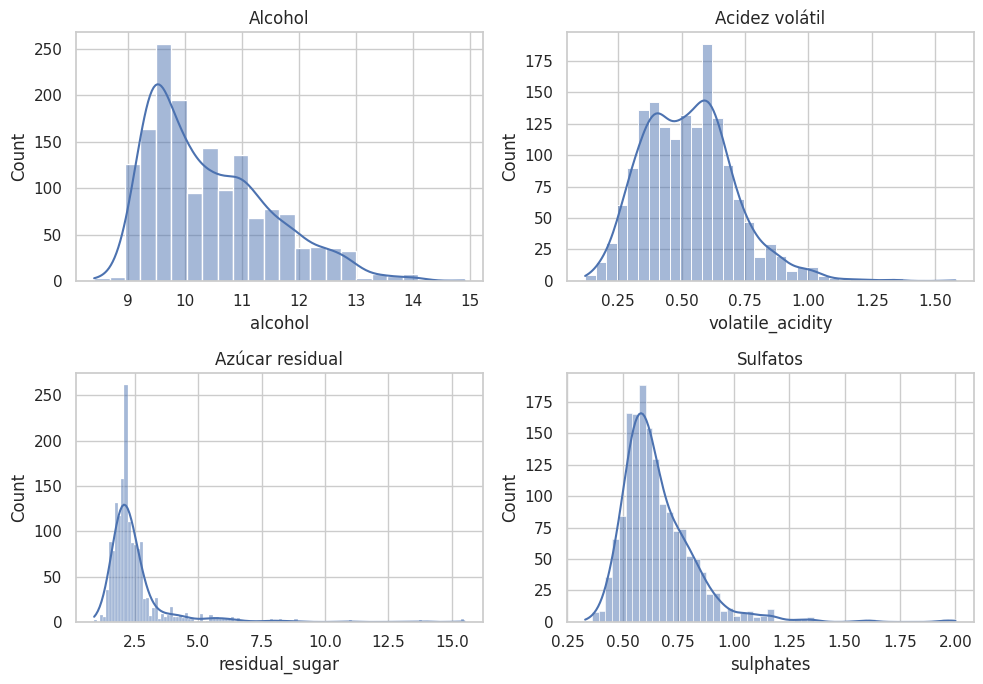

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
sns.histplot(df["alcohol"], kde=True, ax=axs[0,0])
axs[0,0].set_title("Alcohol")
sns.histplot(df["volatile_acidity"], kde=True, ax=axs[0,1])
axs[0,1].set_title("Acidez volátil")
sns.histplot(df["residual_sugar"], kde=True, ax=axs[1,0])
axs[1,0].set_title("Azúcar residual")
sns.histplot(df["sulphates"], kde=True, ax=axs[1,1])
axs[1,1].set_title("Sulfatos")
plt.tight_layout()
plt.show()

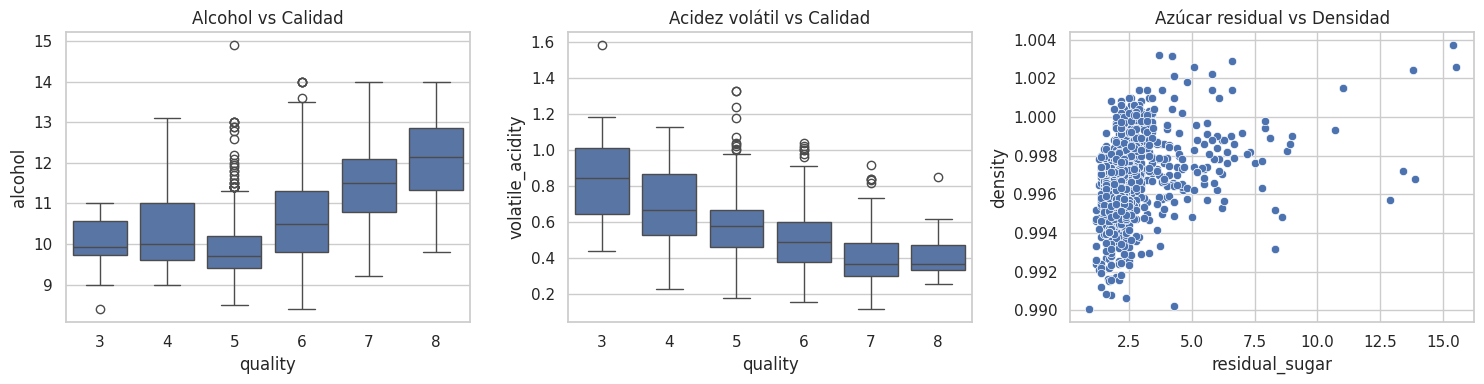

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=df, x="quality", y="alcohol", ax=axs[0])
axs[0].set_title("Alcohol vs Calidad")
sns.boxplot(data=df, x="quality", y="volatile_acidity", ax=axs[1])
axs[1].set_title("Acidez volátil vs Calidad")
sns.scatterplot(data=df, x="residual_sugar", y="density", ax=axs[2])
axs[2].set_title("Azúcar residual vs Densidad")
plt.tight_layout()
plt.show()

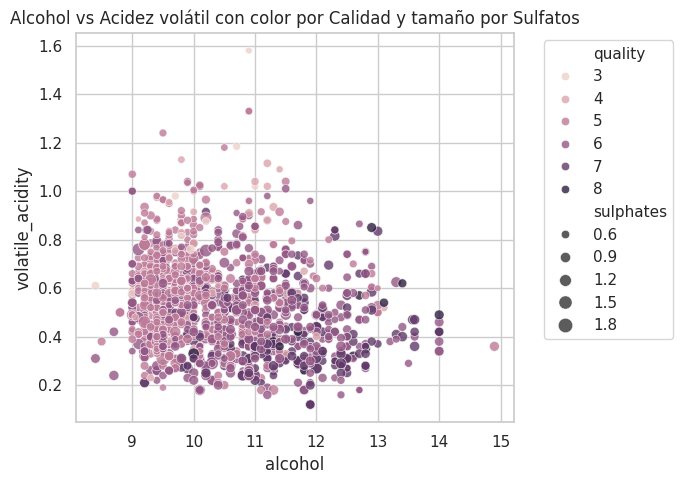

In [28]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="alcohol", y="volatile_acidity", hue="quality", size="sulphates", sizes=(20,120), alpha=0.8)
plt.title("Alcohol vs Acidez volátil con color por Calidad y tamaño por Sulfatos")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

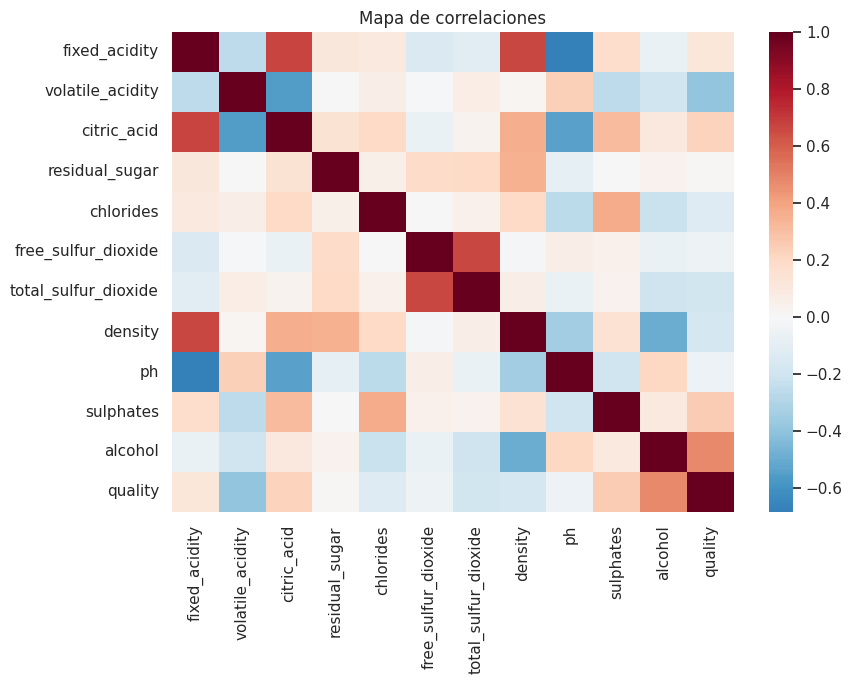

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric_acid,0.226373
fixed_acidity,0.124052
residual_sugar,0.013732
free_sulfur_dioxide,-0.050656
ph,-0.057731
chlorides,-0.128907
density,-0.174919


In [29]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False)
plt.title("Mapa de correlaciones")
plt.tight_layout()
plt.show()
corr["quality"].sort_values(ascending=False)

In [30]:
def iqr_bounds(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return low, high

for col in ["volatile_acidity", "alcohol"]:
    low, high = iqr_bounds(df[col])
    outs = df[(df[col] < low) | (df[col] > high)][col]
    print(col, len(outs))

volatile_acidity 19
alcohol 13


## Conclusiones

Los análisis realizados confirman que la variable alcohol es el principal predictor positivo de la calidad de los vinos tintos en este conjunto de datos. Tanto la correlación (≈ 0,48) como la comparación visual mediante boxplots muestran un aumento claro del contenido alcohólico en los vinos mejor valorados. Esto valida la hipótesis 1 y sugiere que un mayor grado alcohólico, dentro de límites aceptables, contribuye a una percepción más favorable en la cata.

La acidez volátil presenta una relación negativa con la calidad, tal como se planteó en la hipotesis número 2. Los vinos con valores más altos de acidez volátil tienden a concentrarse en calidades intermedias o bajas, lo cual se observó tanto en las correlaciones como en los diagramas de caja por categoría de calidad. Este patrón coincide con la idea de que un exceso de acidez volátil perjudica las características sensoriales.

En cuanto a la hipotesis 3, los sulfatos muestran una relación positiva moderada con la calidad, mientras que el dióxido de azufre total no presenta un patrón tan claro. Esto sugiere que los aditivos con efecto antioxidante podrían contribuir en parte a la preservación y mejora de las características del vino, aunque su influencia no es tan determinante como la del alcohol.

La hipótesis 4 tambien se confirma ya que los resultados muestran que la densidad y azúcar residual están fuertemente correlacionadas. El scatterplot y el coeficiente de correlación cercano a 0,84 muestran que la densidad del vino se explica en gran medida por la cantidad de azúcar disuelta, lo que constituye una relación estructural más que sensorial.